In [62]:
from torchvision import transforms
import random
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split

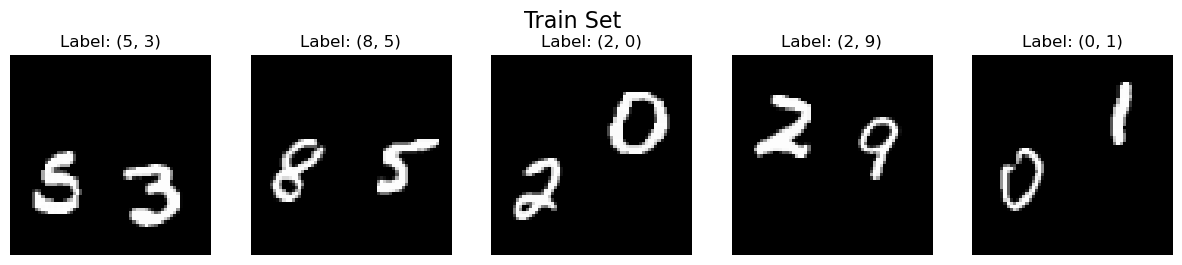

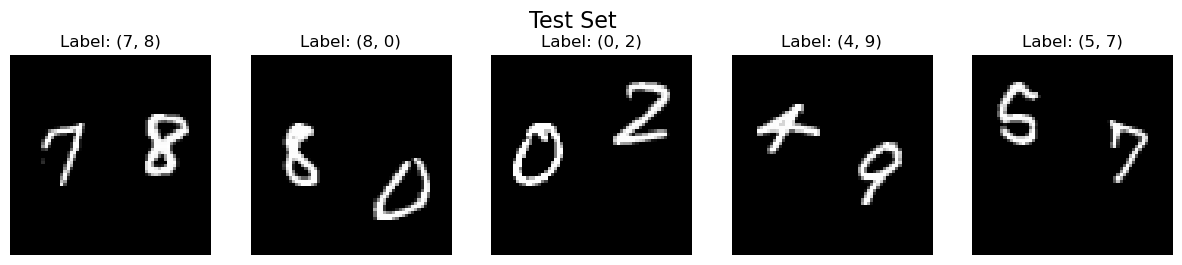

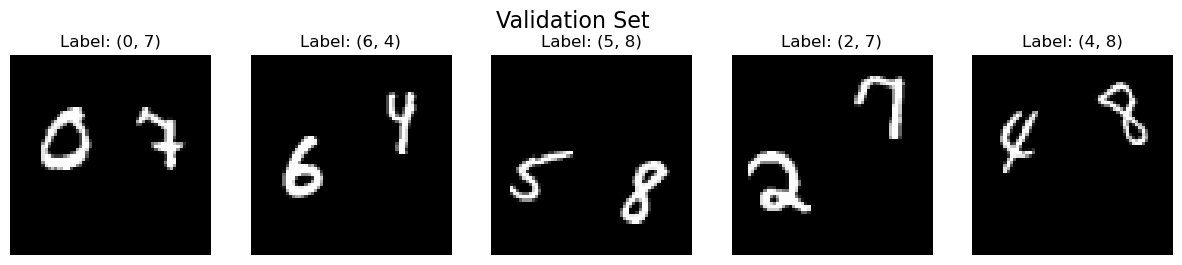

In [63]:
# We delete all 11 22 33 44 55 66 77 88 99 00 to ensure that the model can not train on the same digit

dataset_root = 'double_mnist'  
transform = transforms.Compose([transforms.ToTensor(),  ]) # Converts images to tensors

train_dataset = ImageFolder(root=os.path.join(dataset_root, 'train'), transform=transform)
test_dataset = ImageFolder(root=os.path.join(dataset_root, 'test'), transform=transform)
val_dataset = ImageFolder(root=os.path.join(dataset_root, 'val'), transform=transform)

def extract_image_names_as_labels(dataset_root):
    train_path = os.path.join(dataset_root, 'train')
    val_path = os.path.join(dataset_root, 'val')
    test_path = os.path.join(dataset_root, 'test')
    train_dataset = ImageFolder(root=train_path)
    val_dataset = ImageFolder(root=val_path)
    test_dataset = ImageFolder(root=test_path)

    def extract_labels(samples):
        labels = []
        for sample in samples:
            image_name = os.path.basename(sample[0])
            parts = image_name.split('_')
            second_digit_parts = parts[1].split('.')
            first_digit_second = int(second_digit_parts[0])
            first_digit_second_str = str(first_digit_second)
            first_digit_second_str = '0' * (2 - len(first_digit_second_str)) + first_digit_second_str
            second_digit = int(first_digit_second_str[0])
            third_digit = int(first_digit_second_str[1])
            labels.append((second_digit, third_digit))
        return labels
    y_train = extract_labels(train_dataset.samples)
    y_val = extract_labels(val_dataset.samples)
    y_test = extract_labels(test_dataset.samples)
    return y_train, y_val, y_test

y_train, y_val, y_test = extract_image_names_as_labels(dataset_root)

def plot_images_with_filenames(dataset, title, labels):
    # Select five random samples
    random_samples = random.sample(range(len(dataset)), 5)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, idx in enumerate(random_samples):
        image, _ = dataset[idx]  # Get the image and ignore the label
        axes[i].imshow(image.permute(1, 2, 0).numpy(), cmap='gray')
        axes[i].set_title(f"Label: {labels[idx]}")
        axes[i].axis('off')
    fig.suptitle(title, fontsize=16)
    plt.show()

plot_images_with_filenames(train_dataset, "Train Set", y_train)
plot_images_with_filenames(test_dataset, "Test Set", y_test)
plot_images_with_filenames(val_dataset, "Validation Set", y_val)

In [64]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

num_classes = len(train_dataset.classes)  
model = CNN(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader):.4f}, 'f'Validation Accuracy: {100 * correct / total:.2f}%')

# Testing
test_loss = 0.0
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {100 * correct / total:.2f}%')

Epoch 1/10, Validation Loss: 18.1809, Validation Accuracy: 0.50%
Epoch 2/10, Validation Loss: 19.7272, Validation Accuracy: 0.41%
Epoch 3/10, Validation Loss: 20.6742, Validation Accuracy: 0.63%
Epoch 4/10, Validation Loss: 21.4823, Validation Accuracy: 0.56%
Epoch 5/10, Validation Loss: 23.2388, Validation Accuracy: 0.52%
Epoch 6/10, Validation Loss: 24.7442, Validation Accuracy: 0.95%
Epoch 7/10, Validation Loss: 26.3321, Validation Accuracy: 0.49%
Epoch 8/10, Validation Loss: 28.2786, Validation Accuracy: 0.56%
Epoch 9/10, Validation Loss: 30.5416, Validation Accuracy: 1.06%
Epoch 10/10, Validation Loss: 32.7572, Validation Accuracy: 0.67%
Test Loss: 29.6875, Test Accuracy: 1.99%


In [58]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = 64 * 64 * 3  
hidden_size = 128
num_classes = len(train_dataset.classes)  

model = MLP(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

val_dataset = ImageFolder(root=dataset_root, transform=transform)
test_dataset = ImageFolder(root=dataset_root, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

# Testing
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Epoch 1/10, Validation Loss: 12528.4433, Validation Accuracy: 1.58%
Epoch 2/10, Validation Loss: 16047.4937, Validation Accuracy: 1.85%
Epoch 3/10, Validation Loss: 19029.9061, Validation Accuracy: 1.50%
Epoch 4/10, Validation Loss: 21473.0769, Validation Accuracy: 1.09%
Epoch 5/10, Validation Loss: 21883.7601, Validation Accuracy: 1.45%
Epoch 6/10, Validation Loss: 24765.3495, Validation Accuracy: 1.54%
Epoch 7/10, Validation Loss: 26631.9511, Validation Accuracy: 1.55%
Epoch 8/10, Validation Loss: 29065.0219, Validation Accuracy: 1.30%
Epoch 9/10, Validation Loss: 31415.1403, Validation Accuracy: 1.22%
Epoch 10/10, Validation Loss: 35095.1369, Validation Accuracy: 1.21%
Test Loss: 35095.1369, Test Accuracy: 1.21%


### CNN
Epoch 1/10, Validation Loss: 17.6581, Validation Accuracy: 0.29%
Epoch 2/10, Validation Loss: 19.8326, Validation Accuracy: 0.42%
Epoch 3/10, Validation Loss: 22.0478, Validation Accuracy: 0.09%
Epoch 4/10, Validation Loss: 26.0575, Validation Accuracy: 0.05%
Epoch 5/10, Validation Loss: 28.2018, Validation Accuracy: 0.34%
Epoch 6/10, Validation Loss: 31.0672, Validation Accuracy: 0.12%
Epoch 7/10, Validation Loss: 33.1543, Validation Accuracy: 0.13%
Epoch 8/10, Validation Loss: 34.2694, Validation Accuracy: 0.14%
Epoch 9/10, Validation Loss: 37.5594, Validation Accuracy: 0.12%
Epoch 10/10, Validation Loss: 39.4561, Validation Accuracy: 0.09%
Test Loss: 36.7619, Test Accuracy: 1.44%

### MLP
Epoch 1/10, Validation Loss: 1311.7505, Validation Accuracy: 61.81%
Epoch 2/10, Validation Loss: 1247.0835, Validation Accuracy: 62.53%
Epoch 3/10, Validation Loss: 1209.2983, Validation Accuracy: 63.12%
Epoch 4/10, Validation Loss: 1162.7262, Validation Accuracy: 64.39%
Epoch 5/10, Validation Loss: 1114.8044, Validation Accuracy: 65.35%
Epoch 6/10, Validation Loss: 1074.7367, Validation Accuracy: 66.18%
Epoch 7/10, Validation Loss: 1036.9320, Validation Accuracy: 67.91%
Epoch 8/10, Validation Loss: 996.6466, Validation Accuracy: 69.42%
Epoch 9/10, Validation Loss: 962.6367, Validation Accuracy: 70.60%
Epoch 10/10, Validation Loss: 933.4804, Validation Accuracy: 71.50%
Test Loss: 933.4804, Test Accuracy: 71.50%

# Part 2

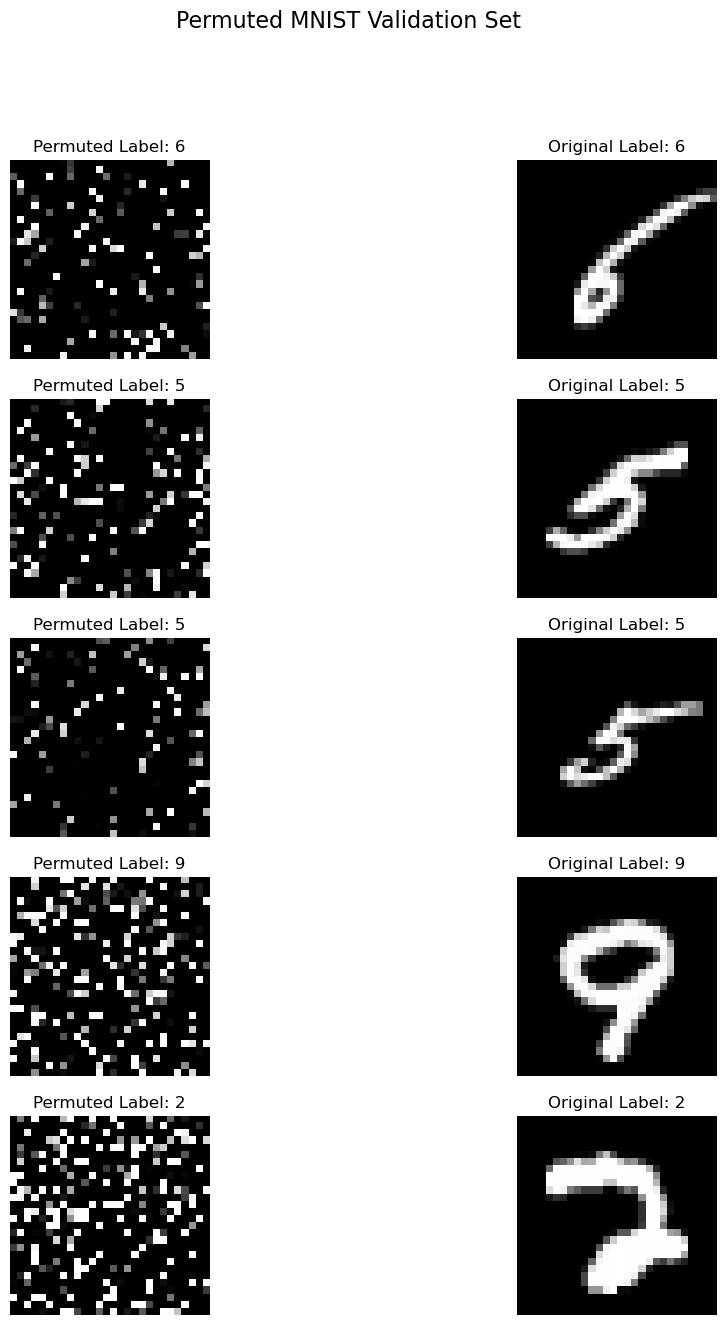

In [52]:
def permute_mnist(mnist, seed):
    random.seed(seed)
    np.random.seed(seed)
    indices = list(range(28*28))
    random.shuffle(indices)
    indices = torch.LongTensor(indices)
    mnist.data = mnist.data.view(mnist.data.shape[0], -1)[:, indices].view(mnist.data.shape)
    return mnist

def plot_permuted_and_original_images(dataset, title, mnist, num_samples=5):
    random_samples = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, num_samples * 3))
    for i, idx in enumerate(random_samples):
        permuted_image, permuted_label = dataset[idx]
        original_image, original_label = mnist[idx]
        axes[i, 0].imshow(permuted_image.permute(1, 2, 0).numpy(), cmap='gray')
        axes[i, 0].set_title(f"Permuted Label: {permuted_label}")
        axes[i, 0].axis('off')
        axes[i, 1].imshow(original_image.permute(1, 2, 0).numpy(), cmap='gray')
        axes[i, 1].set_title(f"Original Label: {original_label}")
        axes[i, 1].axis('off')
    fig.suptitle(title, fontsize=16)
    plt.show()

mnist = MNIST('./data/mnist', train=True, download=True, transform=transforms.ToTensor())
permuted_mnist = permute_mnist(mnist, seed=0)
plot_permuted_and_original_images(permuted_mnist, "Permuted MNIST Validation Set", mnist=MNIST('./data/mnist', train=True, download=True, transform=transforms.ToTensor()))


In [59]:
### CNN ####

batch_size = 64
train_dataset, test_dataset = train_test_split(permuted_mnist, test_size=0.2, random_state=0)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=0)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST
    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)
        x = self.conv2(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    correct = 0
    total = 0
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.2f}%')


# Testing loop
model.eval()
correct = 0
total = 0
for images, labels in test_loader:
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Epoch 1/10, Validation Loss: 0.3436, Validation Accuracy: 90.33%
Epoch 2/10, Validation Loss: 0.2820, Validation Accuracy: 92.81%
Epoch 3/10, Validation Loss: 0.0844, Validation Accuracy: 94.60%
Epoch 4/10, Validation Loss: 0.1957, Validation Accuracy: 94.75%
Epoch 5/10, Validation Loss: 0.0883, Validation Accuracy: 95.26%
Epoch 6/10, Validation Loss: 0.0663, Validation Accuracy: 95.68%
Epoch 7/10, Validation Loss: 0.0794, Validation Accuracy: 95.12%
Epoch 8/10, Validation Loss: 0.0264, Validation Accuracy: 95.24%
Epoch 9/10, Validation Loss: 0.1367, Validation Accuracy: 95.47%
Epoch 10/10, Validation Loss: 0.0712, Validation Accuracy: 95.51%
Test Accuracy: 95.71%


### CNN on perm
Epoch 1/10, Validation Loss: 0.3766, Validation Accuracy: 90.53%
Epoch 2/10, Validation Loss: 0.0584, Validation Accuracy: 94.10%
Epoch 3/10, Validation Loss: 0.1600, Validation Accuracy: 94.79%
Epoch 4/10, Validation Loss: 0.1063, Validation Accuracy: 95.55%
Epoch 5/10, Validation Loss: 0.1193, Validation Accuracy: 94.81%
Epoch 6/10, Validation Loss: 0.0766, Validation Accuracy: 95.84%
Epoch 7/10, Validation Loss: 0.0668, Validation Accuracy: 95.85%
Epoch 8/10, Validation Loss: 0.0858, Validation Accuracy: 95.64%
Epoch 9/10, Validation Loss: 0.0072, Validation Accuracy: 95.64%
Epoch 10/10, Validation Loss: 0.1479, Validation Accuracy: 95.32%
Test Accuracy: 95.51%

In [60]:
permuted_mnist = permute_mnist(mnist, seed=0)
train_size = 0.6
val_size = 0.2
test_size = 0.2
train_data, temp_data = train_test_split(permuted_mnist, train_size=train_size)
val_data, test_data = train_test_split(temp_data, train_size=val_size/(val_size + test_size))
transform = transforms.Compose([transforms.ToTensor()])
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = 28 * 28
hidden_size = 128
num_classes = 10
model = MLP(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = total_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
    # Validation loop
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    for images, labels in val_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    val_loss = total_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Evaluate the model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Epoch 1/10, Training Loss: 0.4228, Training Accuracy: 88.69%
Epoch 1/10, Validation Loss: 0.2434, Validation Accuracy: 93.03%
Epoch 2/10, Training Loss: 0.2047, Training Accuracy: 94.17%
Epoch 2/10, Validation Loss: 0.1850, Validation Accuracy: 94.63%
Epoch 3/10, Training Loss: 0.1470, Training Accuracy: 95.71%
Epoch 3/10, Validation Loss: 0.1442, Validation Accuracy: 95.68%
Epoch 4/10, Training Loss: 0.1114, Training Accuracy: 96.76%
Epoch 4/10, Validation Loss: 0.1225, Validation Accuracy: 96.44%
Epoch 5/10, Training Loss: 0.0891, Training Accuracy: 97.43%
Epoch 5/10, Validation Loss: 0.1191, Validation Accuracy: 96.22%
Epoch 6/10, Training Loss: 0.0723, Training Accuracy: 97.97%
Epoch 6/10, Validation Loss: 0.1078, Validation Accuracy: 96.69%
Epoch 7/10, Training Loss: 0.0605, Training Accuracy: 98.24%
Epoch 7/10, Validation Loss: 0.1032, Validation Accuracy: 96.86%
Epoch 8/10, Training Loss: 0.0490, Training Accuracy: 98.65%
Epoch 8/10, Validation Loss: 0.1060, Validation Accuracy:

### MLP perm
Epoch 1/10, Training Loss: 0.4293, Training Accuracy: 88.37%
Epoch 1/10, Validation Loss: 0.2400, Validation Accuracy: 93.17%
Epoch 2/10, Training Loss: 0.2037, Training Accuracy: 94.13%
Epoch 2/10, Validation Loss: 0.1759, Validation Accuracy: 94.95%
Epoch 3/10, Training Loss: 0.1459, Training Accuracy: 95.76%
Epoch 3/10, Validation Loss: 0.1472, Validation Accuracy: 95.65%
Epoch 4/10, Training Loss: 0.1122, Training Accuracy: 96.79%
Epoch 4/10, Validation Loss: 0.1294, Validation Accuracy: 96.11%
Epoch 5/10, Training Loss: 0.0891, Training Accuracy: 97.38%
Epoch 5/10, Validation Loss: 0.1225, Validation Accuracy: 96.28%
Epoch 6/10, Training Loss: 0.0728, Training Accuracy: 97.88%
Epoch 6/10, Validation Loss: 0.1044, Validation Accuracy: 96.84%
Epoch 7/10, Training Loss: 0.0593, Training Accuracy: 98.34%
Epoch 7/10, Validation Loss: 0.0994, Validation Accuracy: 96.90%
Epoch 8/10, Training Loss: 0.0487, Training Accuracy: 98.63%
Epoch 8/10, Validation Loss: 0.0943, Validation Accuracy: 97.21%
Epoch 9/10, Training Loss: 0.0403, Training Accuracy: 98.91%
Epoch 9/10, Validation Loss: 0.0911, Validation Accuracy: 97.22%
Epoch 10/10, Training Loss: 0.0331, Training Accuracy: 99.11%
Epoch 10/10, Validation Loss: 0.0928, Validation Accuracy: 97.14%
Test Accuracy: 96.95%